CNN Encoder - RNN Decoder - Sequence to Word
====

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import io
import sys
import time
import glob
import pickle
import gc
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from rouge import Rouge

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.config.experimental_run_functions_eagerly(True)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Read a file and return a string
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

Data Transformation
----

In [3]:
dir_name = 'PIX2CODE_COMPILED'
data_dir = '../data_collection/webpages/' + dir_name

IMG_WIDTH = 299
IMG_HEIGHT = 299

# get all image filepaths
list_img = tf.data.Dataset.list_files(str(data_dir + "/*.png"), shuffle=False)

DATASET_SIZE = len(glob.glob(data_dir + "/*.png"))

for f in list_img.take(5):
    print(f.numpy())

b'..\\data_collection\\webpages\\PIX2CODE_COMPILED\\00150311-A7AE-4804-8B7D-9273687B4FC0.png'
b'..\\data_collection\\webpages\\PIX2CODE_COMPILED\\00190F39-0DE9-47EB-B0C2-856FDD3ACE62.png'
b'..\\data_collection\\webpages\\PIX2CODE_COMPILED\\00779BBE-DD64-4909-9909-24F5C8044A7B.png'
b'..\\data_collection\\webpages\\PIX2CODE_COMPILED\\00CDC9A8-3D73-4291-90EF-49178E408797.png'
b'..\\data_collection\\webpages\\PIX2CODE_COMPILED\\00E15BB2-5568-4466-BA18-A8A8D34FC61C.png'


**Image Processing**

In [4]:
# decodes an image string
@tf.function
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    img = tf.image.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                          
    #img = tf.keras.applications.inception_v3.preprocess_input(img)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    # resize the image to the desired size.
    return img

**Sequence Processing**

In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', split=" ", lower=False)
# Create the vocabulary 
tokenizer.fit_on_texts([load_doc('./DSL.vocab')])

# Add padding
tokenizer.word_index['<PAD>'] = 0
tokenizer.index_word[0] = '<PAD>'

In [6]:
def tokenizer_lookup(word):
    return tokenizer.word_index[word.numpy().decode()]

# tensorflow way to convert text to sequence with tokenizer
@tf.function
def text_to_seq(text, tokenizer):
    spl = tf.map_fn(lambda t: tf.py_function(func=tokenizer_lookup, inp=[t], Tout=tf.int32), text, dtype="int32")
    return spl

In [7]:
# converts image filepath to its label
@tf.function
def get_seq(file_path):
    # convert from png to gui file
    path = tf.strings.regex_replace(file_path, ".png", ".gui")
    # read contents and return
    label = tf.constant("<START> ") + tf.io.read_file(path) + tf.constant(" <END>")
    return tf.strings.split(label)

In [8]:
print(tokenizer.index_word)

{1: '{', 2: '}', 3: '<START>', 4: '<END>', 5: 'Body', 6: 'Block', 7: 'Container', 8: 'Row', 9: 'Column', 10: 'Header', 11: 'Footer', 12: 'Paragraph', 13: 'Image', 14: 'Button', 15: 'Subtitle', 16: 'Title', 17: 'Link', 18: 'TextBox', 19: 'CheckBox', 20: 'RadioBox', 21: 'Range', 0: '<PAD>'}


**Combine and Split Datasets**

In [9]:
# does all processing per dataset image path
@tf.function
def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    seq = get_seq(file_path)
    seq = text_to_seq(seq, tokenizer)
    return img, seq

In [10]:
dataset = list_img.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
max_length = dataset.map(lambda _, y: tf.size(y), num_parallel_calls=AUTOTUNE)
max_length = max_length.reduce(tf.constant(0), lambda x, y: tf.math.maximum(x, y))

Image shape:  (299, 299, 3)
Sequence:  ['<START> Body { Header { Button Link Link Link } Row { Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } } <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']


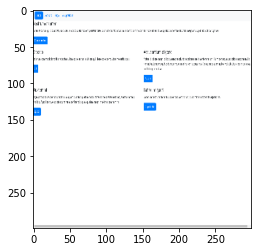

In [12]:
dataset = dataset.map(lambda x, y: (x, tf.concat([y, tf.repeat(0, max_length - tf.size(y))], -1)))

for image, seq in dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Sequence: ", tokenizer.sequences_to_texts([seq.numpy()]))
    plt.imshow(image.numpy())

In [13]:
train_size = int(DATASET_SIZE * 0.7)
val_size = int(DATASET_SIZE * 0.1)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

In [14]:
BATCH_SIZE = 8
BUFFER_SIZE = 50
embedding_dim = 16
encoder_units = 128
decoder_units = 224
num_steps = train_size // BATCH_SIZE
num_val_steps = val_size // BATCH_SIZE
vocab_size = len(tokenizer.word_index) + 1
seq_limit = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Model Definition
----

In [15]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Conv2D(16, (3, 3), padding='valid', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3,)))
        self.model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2))
        self.model.add(tf.keras.layers.Dropout(0.2))
        self.model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
        self.model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2))
        self.model.add(tf.keras.layers.Dropout(0.2))
        self.model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
        self.model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2))
        self.model.add(tf.keras.layers.Dropout(0.2))
        self.model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))

        self.out = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.model(x)
        
        x = self.out(x)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
        
        x = tf.nn.relu(x)
        
        return x

In [16]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        w1 = self.W1(features)
        w2 = self.W2(hidden_with_time_axis)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(w1 + w2)

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [17]:
class RNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, max_length):
        super(RNN_Encoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.gru = tf.keras.models.Sequential()
        self.gru.add(tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform'))
        self.gru.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units, activation='relu')))
        
    def call(self, x):
        x = self.embedding(x)
        x = self.gru(x)
        
        return x
        
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [18]:
class CNN_RNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, max_length):
        super(CNN_RNN_Encoder, self).__init__()
        self.rnn = RNN_Encoder(embedding_dim, units, vocab_size, max_length)
        self.cnn = CNN_Encoder(embedding_dim)
        self.rep = tf.keras.layers.RepeatVector(1)
        self.features = None
        
    def call(self, seq, img=None):
        if img is None and self.features is None:
            print("Error, img and features None")
            return
        elif img is not None:
            self.features = self.cnn(img)
            
        feat = self.rep(self.features)
            
        seq = self.rnn(seq)
        
        x = tf.keras.layers.concatenate([feat, seq])
        return x
    
    def set_features(self, img):
        self.features = self.cnn(img)
    
    def reset_state(self, batch_size):
        self.features = None
        return self.rnn.reset_state(batch_size)

In [19]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.gru = tf.keras.models.Sequential()
        self.gru.add(tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform'))
        self.fc = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):    
        x = self.gru(x)
        
        x = self.fc(x)
        x = self.fc2(x)
        
        return x
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [20]:
class RNN_Encoder_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, max_length):
        super(RNN_Encoder_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru2 = tf.keras.layers.GRU(self.units,
                                   return_sequences=False,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.rep = tf.keras.layers.RepeatVector(max_length)
        self.attention = BahdanauAttention(self.units)
        
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        
        x = self.embedding(x)
        
        feat = self.rep(context_vector)
    
        x = tf.keras.layers.concatenate([feat, x])
        
        output, state = self.gru2(x)

        x = self.fc1(output)

        # x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)
        
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [21]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Encoder_Decoder(embedding_dim, decoder_units, vocab_size, seq_limit)

In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [23]:
checkpoint_path = "./checkpoints/cnn_rnn_s2w_att/exp/nd/again"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [24]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = (int(ckpt_manager.latest_checkpoint.split('-')[-1]) - 1) * 5
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

Model Training
----

In [25]:
def save_plot(plot_path, plot_list):
    with open(plot_path, 'wb') as fp:
        pickle.dump(plot_list, fp)
        
def load_plot(plot_path):
    with open (plot_path, 'rb') as fp:
         return pickle.load(fp)

In [26]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
val_plot = []
# loss_plot = load_plot("./checkpoints/cnn_rnn_s2w_att/exp/nd/loss_plot")
# val_plot = load_plot("./checkpoints/cnn_rnn_s2w_att/exp/nd/val_plot")

In [27]:
@tf.function
def pad_tensor_sequence(seq):
    return tf.pad(seq, [[0, 0], [0, seq_limit - seq.shape[1]]], "CONSTANT")

In [28]:
@tf.function
def train_step(img_tensor, target, val=False):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<START>']] * target.shape[0], 1)
    dec_input = pad_tensor_sequence(dec_input)
    
    if val:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.slice(dec_input, [0, 1 if i - seq_limit >= 0 else 0], [-1, min(i, seq_limit - 1)])
            dec_input = tf.concat([dec_input, tf.expand_dims(target[:, i], 1)], 1)
            dec_input = pad_tensor_sequence(dec_input)

        total_loss = (loss / int(target.shape[1]))
        return loss, total_loss

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.slice(dec_input, [0, 1 if i - seq_limit >= 0 else 0], [-1, min(i, seq_limit - 1)])
            dec_input = tf.concat([dec_input, tf.expand_dims(target[:, i], 1)], 1)
            dec_input = pad_tensor_sequence(dec_input)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [29]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    total_val_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 20 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
            epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
            print ('Time taken for Batches {} sec'.format(time.time() - start))
    
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        _, t_loss = train_step(img_tensor, target, True)
        total_val_loss += t_loss
            
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    val_plot.append(total_val_loss / num_val_steps)

    if (epoch + 1) % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} Val Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, total_val_loss/num_val_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.7542
Time taken for Batches 4.793972969055176 sec
Epoch 1 Batch 20 Loss 1.3425
Time taken for Batches 34.06970930099487 sec
Epoch 1 Batch 40 Loss 1.1979
Time taken for Batches 64.37741112709045 sec
Epoch 1 Batch 60 Loss 1.2557
Time taken for Batches 93.78285336494446 sec
Epoch 1 Batch 80 Loss 1.2093
Time taken for Batches 123.34122920036316 sec
Epoch 1 Batch 100 Loss 1.2723
Time taken for Batches 153.3135621547699 sec
Epoch 1 Batch 120 Loss 1.1177
Time taken for Batches 185.7828369140625 sec
Epoch 1 Batch 140 Loss 1.1941
Time taken for Batches 217.1678512096405 sec
Epoch 1 Loss 1.207386 Val Loss 1.021586
Time taken for 1 epoch 267.1571247577667 sec

Epoch 2 Batch 0 Loss 0.9208
Time taken for Batches 2.3945817947387695 sec
Epoch 2 Batch 20 Loss 0.8609
Time taken for Batches 32.81132745742798 sec
Epoch 2 Batch 40 Loss 0.8481
Time taken for Batches 63.10125160217285 sec
Epoch 2 Batch 60 Loss 0.7470
Time taken for Batches 93.50699782371521 sec
Epoch 2 Batch 80 Loss 0

Epoch 13 Batch 0 Loss 0.0506
Time taken for Batches 2.560051441192627 sec
Epoch 13 Batch 20 Loss 0.0524
Time taken for Batches 33.13342094421387 sec
Epoch 13 Batch 40 Loss 0.0421
Time taken for Batches 63.914703130722046 sec
Epoch 13 Batch 60 Loss 0.0657
Time taken for Batches 95.69995713233948 sec
Epoch 13 Batch 80 Loss 0.0583
Time taken for Batches 126.35962009429932 sec
Epoch 13 Batch 100 Loss 0.0564
Time taken for Batches 156.7670726776123 sec
Epoch 13 Batch 120 Loss 0.0459
Time taken for Batches 187.74928092956543 sec
Epoch 13 Batch 140 Loss 0.0499
Time taken for Batches 218.70273303985596 sec
Epoch 13 Loss 0.051772 Val Loss 0.044436
Time taken for 1 epoch 269.28922867774963 sec

Epoch 14 Batch 0 Loss 0.0477
Time taken for Batches 2.472853660583496 sec
Epoch 14 Batch 20 Loss 0.0487
Time taken for Batches 33.902761936187744 sec
Epoch 14 Batch 40 Loss 0.0404
Time taken for Batches 64.91180753707886 sec
Epoch 14 Batch 60 Loss 0.0403
Time taken for Batches 98.24311137199402 sec
Epoch 

Model Evaluation
----

In [30]:
# save_plot("./checkpoints/cnn_rnn_s2w_att/exp/nd/loss_plot", loss_plot)
# save_plot("./checkpoints/cnn_rnn_s2w_att/exp/nd/val_plot", val_plot)

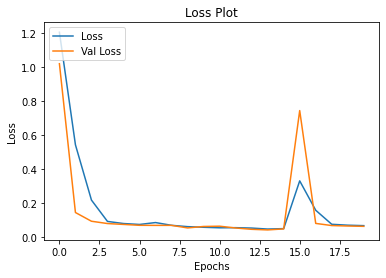

In [31]:
plt.plot(loss_plot)
plt.plot(val_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(['Loss', 'Val Loss'], loc='upper left')
plt.show()

In [32]:
def evaluate(image):
    attention_plot = np.zeros((max_length, 1444))
    
    hidden = decoder.reset_state(batch_size=1)

    features = encoder(tf.expand_dims(image, 0))

    dec_input = tf.expand_dims([tokenizer.word_index['<START>']], 0)
    dec_input = pad_tensor_sequence(dec_input)
    result = ['<START>']

    for i in range(1, max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<END>':
            return result, attention_plot

        dec_input = tf.slice(dec_input, [0, 1 if i - seq_limit >= 0 else 0], [-1, min(i, seq_limit - 1)])
        dec_input = tf.concat([dec_input, tf.expand_dims([predicted_id], 1)], 1)
        dec_input = pad_tensor_sequence(dec_input)

    return result, attention_plot

In [33]:
def eval_path(imgpath):
    return evaluate(process_img_path(imgpath))

In [34]:
def plot_attention(image, result, attention_plot, lim=None):
    fig = plt.figure(figsize=(10, 10))
    
    if lim is None:
        lim = len(result)

    for l in range(lim):
        temp_att = np.resize(attention_plot[l], (38, 38))
        ax = fig.add_subplot(lim//2, lim//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Actual DSL:  <START> Body { Header { Link Button Link Link } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } } <END>                        

Predicted DSL:  <START> Body { Header { Link Button } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } } <END>


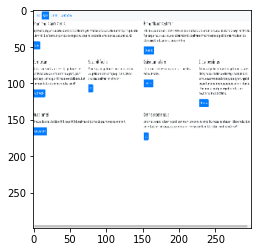

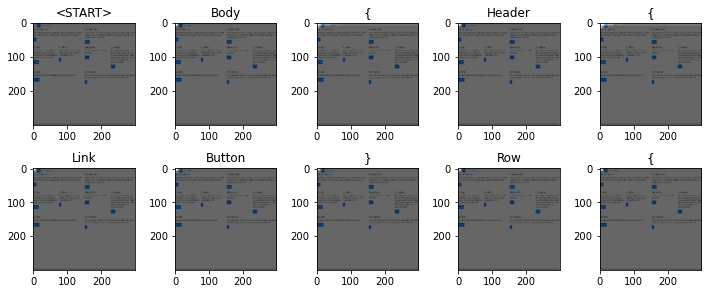

In [35]:
test_entry = test_dataset.take(1)

for image, seq in test_entry:
    actual = tokenizer.sequences_to_texts([seq.numpy()])[0].replace("<PAD>", "")
    predicted, attention = evaluate(image)
    predicted = ' '.join(predicted)
    plt.imshow(image.numpy())
    print("Actual DSL: ", actual)
    print("\nPredicted DSL: ", predicted)
    plot_attention(image.numpy(), predicted.split(), attention, 10)

In [36]:
def score(dataset, verbose=False):
    actual, predicted = list(), list()
    i = 0
    for image, seq in dataset:
        act = tokenizer.sequences_to_texts([seq.numpy()])[0].replace("<PAD>", "").split()
        pred, _ = evaluate(image)
        pred = ["<START>"] + pred
        if verbose:
            print("\n\nActual DSL---->\n", act)
            print("\nPredicted DSL---->\n", pred)
        else:
            print("Predicted count: " + str(i + 1), end='\r', flush=True)
        actual.append([act])
        predicted.append(pred)
        i += 1
    bleu = corpus_bleu(actual, predicted)
    
    _actual = list(map(lambda p: ' '.join(p[0]), actual))
    _predicted = list(map(lambda p: ' '.join(p), predicted))
    _rouge = Rouge()
    rouge = _rouge.get_scores(_predicted, _actual, avg=True)
    return bleu, rouge,  actual, predicted
        
bleu, rouge, actual, predicted = score(test_dataset)

In [37]:
print(bleu)
print(rouge)

0.8419945247553935
{'rouge-1': {'f': 0.8781900525000437, 'p': 0.8794890616700627, 'r': 0.9208048954895043}, 'rouge-2': {'f': 0.8602516039122572, 'p': 0.8621601093118288, 'r': 0.9030381451804509}, 'rouge-l': {'f': 0.9986438873397846, 'p': 0.9997619047619046, 'r': 0.9976190476190476}}
